# 06wk-1: 영상 자료 분류

최규빈  
2024-10-17

<a href="https://colab.research.google.com/github/guebin/MP2024/blob/main/posts/06wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [1]:
# {{<video https://youtu.be/playlist?list=PLQqh36zP38-xVu7C7RnIszcBO3yGUbR0s&si=vT4OKdaxP4GPQWlF >}}

# 2. ref

ref:
<https://huggingface.co/docs/transformers/tasks/video_classification>

`-` 실행이 되지 않음

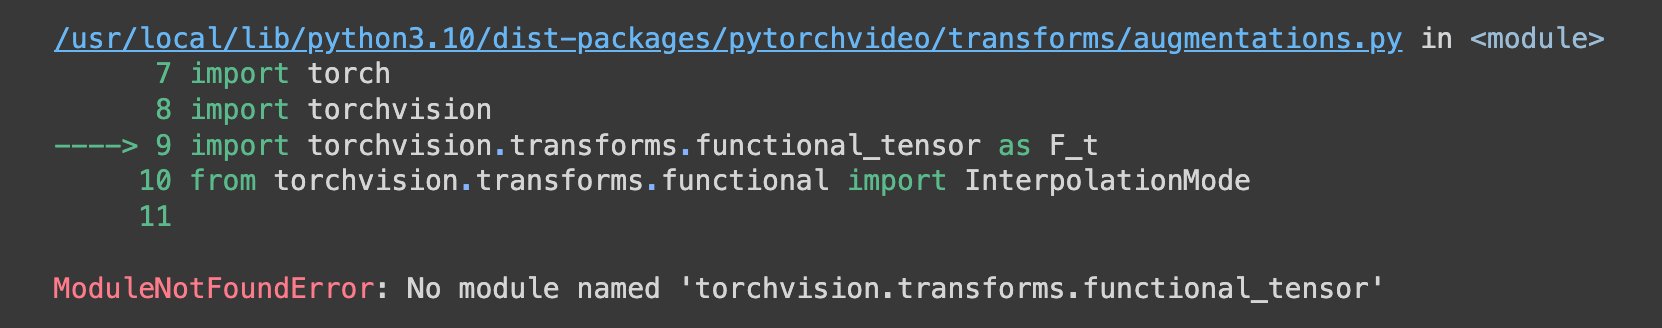

`-` 해결방법:

1.  위의 그림에서
    `/usr/local/lib/python3.10/dist-packages/pytorchvideo/transforms/augmentations.py`
    를 클릭
2.  아래의 그림과 같이 코드를 수정

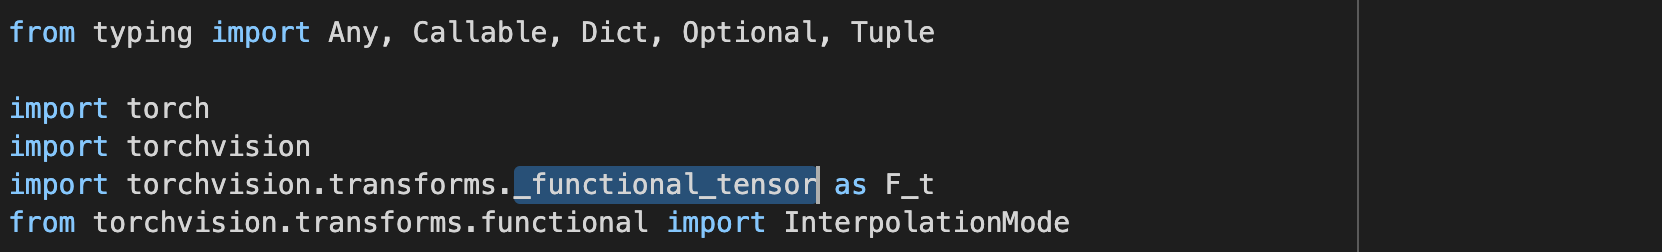

# 3. 예비학습

In [158]:
import matplotlib.pyplot as plt 
import numpy as np
import torch
import imageio
import IPython.display

## A. 이미지 자료의 이해

`-` `plt.imshow(...)` 에서 `...` 자리에 오는 numpy array의 shape이
(??,??) 와 같이 2차원 꼴이면 흑백이미지를 출력

In [9]:
np.array([[0, 150], [0,255]])

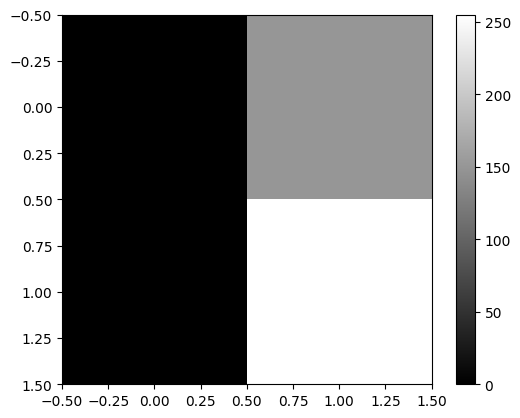

In [12]:
plt.imshow(np.array([[0, 150], [0,255]]),cmap='gray')
plt.colorbar()

`-` `plt.imshow(...)` 에서 `...` 자리에 오는 numpy array의 shape이
(??,??,3) 이러한 형태이면 칼라이미지를 출력

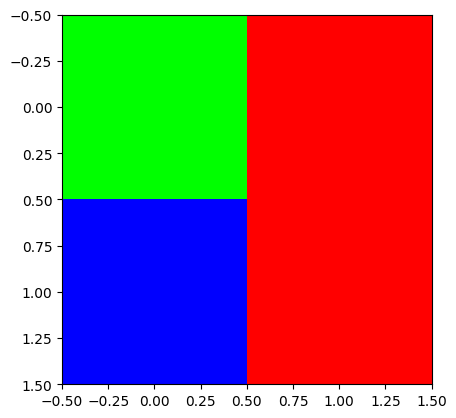

In [27]:
R = np.array([[0,255],
              [0,255]])
G = np.array([[255,0],
              [0,  0]])
B = np.array([[0,  0],
              [255,0]])
plt.imshow(np.stack([R,G,B],axis=-1))

`-` `plt.imshow(...)`에서 `...` 자리에 오는 numpy array 의 dtype이
int인지 float인지에 따라서 시각화 결과가 다름

-   int일 경우: 0을 최소값, 255를 최대값으로 생각하고 그림을 그려줌.
-   float일 경우: 0.0을 최소값, 1.0을 최대값으로 생각하고 그림을 그려줌.

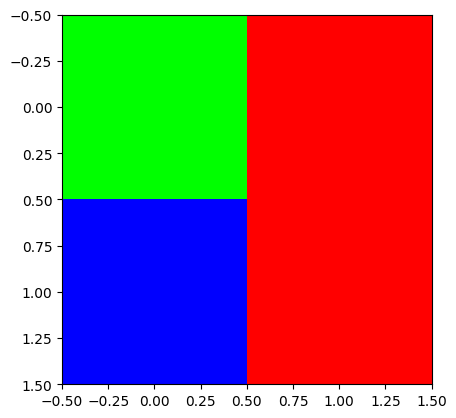

In [43]:
R = np.array([[0,1],
              [0,1]])
G = np.array([[1,0],
              [0,0]])
B = np.array([[0,0],
              [1,0]])
#plt.imshow(np.stack([R,G,B],axis=-1))
plt.imshow(np.stack([R,G,B],axis=-1).astype(float))

## B. `tsr.permute()`

`-` 실수로 R,G,B 를 이상한 방식으로 stack 했다고 가정하자.

In [51]:
R = np.array([[0,255],[0,255]])
G = np.array([[255,0],[0,0]])
B = np.array([[0,0],[255,0]])
# img = np.stack([R,G,B],axis=-1) # <-- 원래는 이걸 하려고 했었음.. 
img = np.stack([R,G,B]) # <-- 실수로 이렇게 만들었다고 하자... 
imgb.shape

`-` 차원이 맞지 않아서 `plt.imshow(img)`이 동작하지 않음. 동작하기
위해서는 `plt.imshow(...)` 에서 `...` 자리에 있는 numpy array가 HWC 와
같은 형식으로 되어야함. (그런데 지금은 CHW 임)

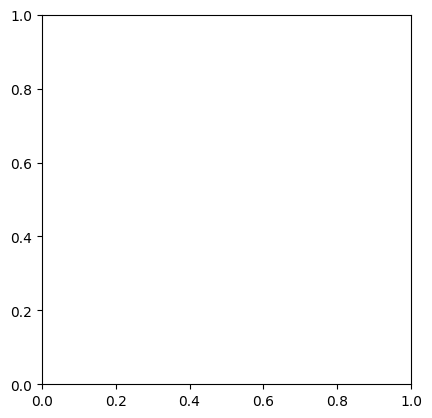

In [53]:
plt.imshow(img)

`-` 에러를 피하기 위해서는 차원을 `(3,2,2)` 에서 `(2,2,3)` 으로
바꾸어야함.

In [58]:
img.reshape(2,2,3)

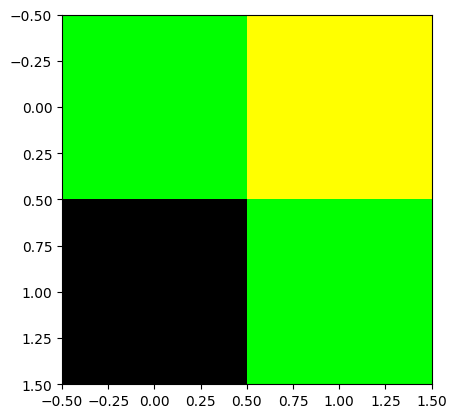

In [60]:
plt.imshow(img.reshape(2,2,3)) # ?? 이상한 그림이 나왔음

-   우리가 원하는 그림은 아니네??
-   왜 이런일이 생기는가??

`-` 이미지자료의 차원을 바꾸고 싶다면 `reshape`을 쓰지 말고
`np.transpose`를 이용하라

In [75]:
img.reshape(2,2,3),  np.transpose(img,(1,2,0)) 

-   위의 두개의 array는 차원이 같음. $\to$ 그림자체는 둘다 그려짐
-   그렇지만 같은 array는 아님 $\to$ 당연히 그림도 달라짐

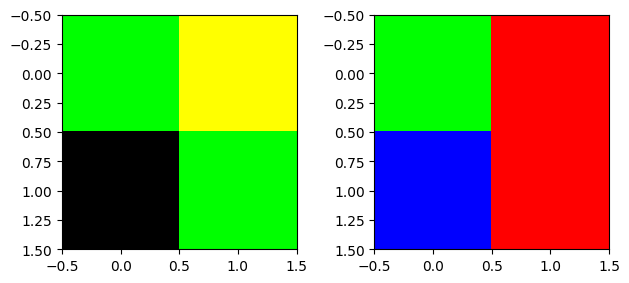

In [74]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(img.reshape(2,2,3))
ax[1].imshow(np.transpose(img, (1,2,0)))
fig.tight_layout()

-   왼쪽은 이상한 그림, 오른쪽은 우리가 원하는 그림

`-` numpy array 가 아니고 pytorch tensor 일 경우에는 아래의 방법으로
변환

In [96]:
arr = np.random.rand(2,4,3) 
tsr = torch.tensor(arr)

In [102]:
np.transpose(arr,(2,0,1)) # (2,4,3) --> (3,2,4) 

In [107]:
tsr.permute(2,0,1) # (2,4,3) --> (3,2,4) 
# np.transpose(tsr,(2,0,1)) # 같은코드

## C. 영상 자료 이해

`-` 영상자료 = 여러사진들의 모음 = \[사진1, 사진2, 사진3, 사진4, ….\]

In [130]:
np.random.seed(43052)
v = (np.random.rand(4,60,60,3)*255).astype("uint8")
v[0,:,:,0] = 255 # 첫번쨰 프레임의 R 채널을 모두 최대치로 설정 
v[1,:,:,1] = 255 # 두번쨰 프레임의 G 채널을 모두 최대치로 설정 
v[2,:,:,2] = 255 # 세번째 프레임의 B 채널을 모두 최대치로 설정 

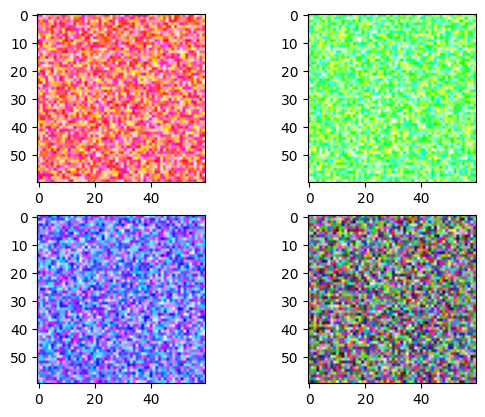

In [145]:
fig, ax = plt.subplots(2,2)
# ax[0][0].imshow(v[0,:,:,:])
# ax[0][1].imshow(v[1,:,:,:])
# ax[1][0].imshow(v[2,:,:,:])
# ax[1][1].imshow(v[3,:,:,:])
ax[0][0].imshow(v[0])
ax[0][1].imshow(v[1])
ax[1][0].imshow(v[2])
ax[1][1].imshow(v[3])

In [149]:
frames = [frame for frame in v]
#frames = [사진1, 사진2, 사진3, 사진4] 

In [155]:
imageio.mimsave("sample.gif",frames)

In [157]:
IPython.display.Image("sample.gif")

## D. `np.clip()`

In [159]:
arr = np.array([[300, -20, 150], [400, 100, 0], [255, 500, -100]])
arr

In [160]:
np.clip(arr,0,255)